In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr

tqdm.pandas()

In [2]:
cis_eQTL = pd.read_csv("~/Downloads/ciseqtl.csv", sep="\t", skiprows=10) # TODO: should also get the trans-eqtl
cis_eQTL

,SNP,Alleles,Alteration number,Gene,Beta,t-stat,p-value,FDR
0,chr4_16921004,G_A,8,AT4G34410,1.521871,10.851752,3.660000e-25,2.220000e-16
1,chr4_16921058,C_T,7,AT4G34410,1.522742,10.075851,3.710000e-22,5.630000e-14
2,chr4_16921082,G_A,7,AT4G34410,1.522742,10.075851,3.710000e-22,5.630000e-14
3,chr4_16921087,G_A,7,AT4G34410,1.522742,10.075851,3.710000e-22,5.630000e-14
4,chr1_4413178,T_G,7,AT1G13310,0.285199,9.702487,9.130000e-21,1.110000e-12
...,...,...,...,...,...,...,...,...
11791,chr5_6992351,G_C,65,AT5G19530,-0.541636,-4.949550,9.690000e-07,4.995519e-02
11792,chr5_5590529,G_A,55,AT5G16180,-0.605012,-4.949497,9.690000e-07,4.996061e-02
11793,chr1_3838815,G_T,122,AT1G13180,-0.398349,-4.949494,9.690000e-07,4.996061e-02
11794,chr1_25212598,T_G,137,AT1G65540,0.404604,4.949454,9.690000e-07,4.996626e-02


In [3]:
#df = pd.read_parquet("../mlm/vep.parquet")
#df = df[df.AN >= 2000]
#df = df[(df.AC != 0) & (df.AC != df.AN)]
#df["alt_AF"] = df.AC / df.AN
#df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
#df["ref_AF"] = 1 - df.alt_AF
#df["alt_AC"] = df.AC
#df["ref_AC"] = df.AN - df.AC
#df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
#df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
#df

In [4]:
df = pd.read_parquet("vep.parquet")
pred_cols = df.columns[(df.columns.str.startswith("DHS_"))|(df.columns.str.startswith("HM_"))|(df.columns.str.startswith("TFBS_"))] # here can actually filter for TF's, for example
df = df[df.AN >= 2000]
df = df[(df.AC != 0) & (df.AC != df.AN)]
df["alt_AF"] = df.AC / df.AN
df["ref_AF"] = 1 - df.alt_AF
df["alt_AC"] = df.AC
df["ref_AC"] = df.AN - df.AC
df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,DHS_Ath_flower_14_days,DHS_Ath_open_flower_normal,...,TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,TFBS_AT5G65310_Ath_seedling_normal,TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,TFBS_AT5G67300_Ath_seedling_normal,TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1,alt_AF,ref_AF,alt_AC,ref_AC,AF
0,Chr5,4014,G,A,12,2242,AT5G01010.2,980,-0.352809,-0.108418,...,0.038344,-0.000864,0.083597,0.049786,0.129127,0.005352,0.994648,12,2230,0.005352
1,Chr5,4051,T,C,12,2218,AT5G01010.2,943,0.097200,0.099005,...,-0.019211,0.058068,0.041719,0.147327,0.013399,0.005410,0.994590,12,2206,0.005410
2,Chr5,4053,A,C,2,2230,AT5G01010.2,941,0.023971,0.068407,...,0.053585,0.068530,0.021884,0.084291,0.124229,0.000897,0.999103,2,2228,0.000897
3,Chr5,4128,G,A,36,2238,AT5G01010.2,866,-0.162379,-0.160685,...,-0.104677,-0.073426,-0.074594,-0.049419,-0.028360,0.016086,0.983914,36,2202,0.016086
4,Chr5,4144,T,C,12,2224,AT5G01010.2,850,-0.069134,-0.187080,...,-0.008571,-0.084561,0.122195,0.193924,-0.012261,0.005396,0.994604,12,2212,0.005396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902800,Chr5,26971544,T,C,46,2230,AT5G67640.1,-903,-0.195258,0.265576,...,-0.583392,-0.560816,-0.271024,-0.237077,-0.435694,0.020628,0.979372,46,2184,0.020628
902801,Chr5,26971553,C,A,2,2246,AT5G67640.1,-912,-0.107909,-0.059501,...,0.248182,0.291140,-0.039106,0.015636,0.089024,0.000890,0.999110,2,2244,0.000890
902802,Chr5,26971566,C,T,2,2250,AT5G67640.1,-925,0.123992,0.411351,...,0.719052,0.739429,0.870852,0.810879,0.422014,0.000889,0.999111,2,2248,0.000889
902803,Chr5,26971596,C,T,2,2234,AT5G67640.1,-955,0.498847,0.565234,...,0.793691,0.720596,0.551410,0.344777,0.113692,0.000895,0.999105,2,2232,0.000895


In [5]:
df[["AN", "AC", "AF"]].describe()

,AN,AC,AF
count,645132.000000,645132.000000,645132.000000
mean,2166.181364,72.262213,0.033699
std,64.262439,175.453285,0.082126
min,2000.000000,2.000000,0.000881
25%,2126.000000,2.000000,0.000927
50%,2182.000000,6.000000,0.002710
75%,2218.000000,36.000000,0.016848
max,2270.000000,1114.000000,0.500000


In [6]:
values = df[pred_cols].values
df.loc[:, "delta_pred_l1_norm"] = np.linalg.norm(values, ord=1, axis=1)
df.loc[:, "delta_pred_l2_norm"] = np.linalg.norm(values, ord=2, axis=1)
df.loc[:, "delta_pred_linf_norm"] = np.linalg.norm(values, ord=np.inf, axis=1)
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,DHS_Ath_flower_14_days,DHS_Ath_open_flower_normal,...,TFBS_AT5G67300_Ath_seedling_normal,TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1,alt_AF,ref_AF,alt_AC,ref_AC,AF,delta_pred_l1_norm,delta_pred_l2_norm,delta_pred_linf_norm
0,Chr5,4014,G,A,12,2242,AT5G01010.2,980,-0.352809,-0.108418,...,0.049786,0.129127,0.005352,0.994648,12,2230,0.005352,13.948242,1.659533,0.385360
1,Chr5,4051,T,C,12,2218,AT5G01010.2,943,0.097200,0.099005,...,0.147327,0.013399,0.005410,0.994590,12,2206,0.005410,12.312111,1.490822,0.347635
2,Chr5,4053,A,C,2,2230,AT5G01010.2,941,0.023971,0.068407,...,0.084291,0.124229,0.000897,0.999103,2,2228,0.000897,9.063315,1.094503,0.345485
3,Chr5,4128,G,A,36,2238,AT5G01010.2,866,-0.162379,-0.160685,...,-0.049419,-0.028360,0.016086,0.983914,36,2202,0.016086,11.498808,1.290090,0.245797
4,Chr5,4144,T,C,12,2224,AT5G01010.2,850,-0.069134,-0.187080,...,0.193924,-0.012261,0.005396,0.994604,12,2212,0.005396,21.640704,2.661350,0.783635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902800,Chr5,26971544,T,C,46,2230,AT5G67640.1,-903,-0.195258,0.265576,...,-0.237077,-0.435694,0.020628,0.979372,46,2184,0.020628,31.661374,3.666639,0.799357
902801,Chr5,26971553,C,A,2,2246,AT5G67640.1,-912,-0.107909,-0.059501,...,0.015636,0.089024,0.000890,0.999110,2,2244,0.000890,13.547881,1.691268,0.497646
902802,Chr5,26971566,C,T,2,2250,AT5G67640.1,-925,0.123992,0.411351,...,0.810879,0.422014,0.000889,0.999111,2,2248,0.000889,48.006609,5.337409,1.021884
902803,Chr5,26971596,C,T,2,2234,AT5G67640.1,-955,0.498847,0.565234,...,0.344777,0.113692,0.000895,0.999105,2,2232,0.000895,44.219459,4.806718,0.934339


In [7]:
#delta_norm = "delta_pred_l1_norm"
delta_norm = "delta_pred_l2_norm"
#delta_norm = "delta_pred_linf_norm"
#delta_norm = "model_llr"

In [8]:
df["SNP_matching_id"] = df.chromosome.str.lower() + "_" + (df.pos+1).astype(str)
df["eQTL"] = df.SNP_matching_id.isin(cis_eQTL.SNP.values)
df.eQTL.value_counts()
# TODO: should match AF in eQTL and noneQTL to be compared

False    644068
True       1064
Name: eQTL, dtype: int64

In [9]:
df["Singleton"] = df.AC == 2
df.Singleton.value_counts()

False    403101
True     242031
Name: Singleton, dtype: int64

In [10]:
#df["logAF"] = np.log(df.AF)
#sns.histplot(data=df, x="logAF", y="delta_pred_l2_norm", bins=300)

In [11]:
#df["logAF_bin"] = pd.cut(df.logAF, 5)

In [12]:
#spearmanr(df.AC.values, df[delta_norm].values)

In [13]:
df.AC.max()

1114

In [14]:
df["AC_bin"] = pd.cut(df.AC, [0.0, 2.0, 10.0, 100.0, 300.0, 1115.0])
df.AC_bin.value_counts()

(0.0, 2.0]         242031
(10.0, 100.0]      153733
(2.0, 10.0]        148775
(100.0, 300.0]      50788
(300.0, 1115.0]     49805
Name: AC_bin, dtype: int64

In [15]:
global_percentile_99 = np.percentile(df[delta_norm], 99)
global_percentile_1 = np.percentile(df[delta_norm], 1)
global_percentile_1, global_percentile_99

(0.63984265666934, 9.926142311152564)

In [16]:
category = "AC_bin"
#category = "logAF_bin"
#category = "Singleton"
#category = "eQTL"

<AxesSubplot:xlabel='AC_bin', ylabel='Above_99_percentile_delta_norm'>

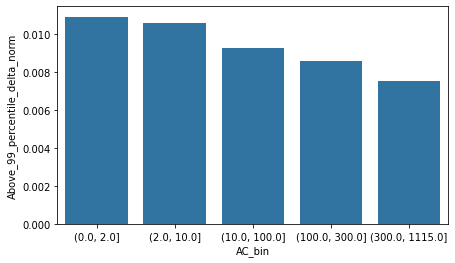

In [17]:
df["Above_99_percentile_delta_norm"] = df[delta_norm] > global_percentile_99
df2 = df.groupby(category)["Above_99_percentile_delta_norm"].mean().to_frame().reset_index()
plt.figure(figsize=(7, 4))
sns.barplot(data=df2, x=category, y="Above_99_percentile_delta_norm", color="C0")
# TODO: could plot a horizontal line at 1 percent. also express it as 1 percent instead of 0.01

In [18]:
#df["below_1_percentile_delta_norm"] = df[delta_norm] < global_percentile_1
#df2 = df.groupby(category)["below_1_percentile_delta_norm"].mean().to_frame().reset_index()
#plt.figure(figsize=(7, 4))
#sns.barplot(data=df2, x=category, y="below_1_percentile_delta_norm", color="C0")

In [19]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

percentiles = [95, 99, 99.9]

groupby = df.groupby(category)[delta_norm].agg([percentile(p) for p in percentiles])
#print(groupby)
x = groupby.melt(ignore_index=False).reset_index()
x

,AC_bin,variable,value
0,"(0.0, 2.0]",percentile_95,6.000106
1,"(2.0, 10.0]",percentile_95,5.972102
2,"(10.0, 100.0]",percentile_95,5.869077
3,"(100.0, 300.0]",percentile_95,5.693749
4,"(300.0, 1115.0]",percentile_95,5.562541
5,"(0.0, 2.0]",percentile_99,10.201247
6,"(2.0, 10.0]",percentile_99,10.054043
7,"(10.0, 100.0]",percentile_99,9.707802
8,"(100.0, 300.0]",percentile_99,9.425726
9,"(300.0, 1115.0]",percentile_99,9.201448


<AxesSubplot:xlabel='variable', ylabel='value'>

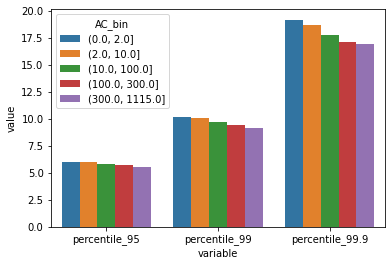

In [20]:
sns.barplot(data=x, x="variable", y="value", hue=category)

<AxesSubplot:xlabel='AF', ylabel='delta_pred_l2_norm'>

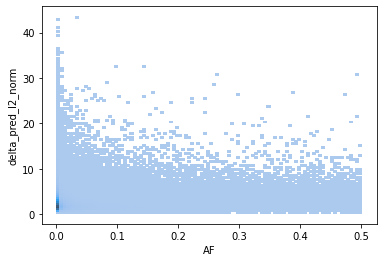

In [21]:
sns.histplot(data=df, x="AF", y=delta_norm, bins=100)  # should normalize across rows
# else make different histograms for each
# like example here: https://seaborn.pydata.org/examples/kde_ridgeplot.html
# else this can be misleading.

In [22]:
df_eQTL = df[df.eQTL]
df_eQTL = df_eQTL.merge(cis_eQTL, how="left", left_on="SNP_matching_id", right_on="SNP").sort_values(["chromosome", "pos"])
df_eQTL

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,DHS_Ath_flower_14_days,DHS_Ath_open_flower_normal,...,AC_bin,Above_99_percentile_delta_norm,SNP,Alleles,Alteration number,Gene,Beta,t-stat,p-value,FDR
0,Chr5,144639,C,G,236,2036,AT5G01340.1,81,-0.174608,-0.123825,...,"(100.0, 300.0]",False,chr5_144640,C_G,67,AT5G01330,0.468163,5.581416,3.620000e-08,0.008654
1,Chr5,170978,T,A,132,2182,AT5G01400.1,94,-0.174366,-0.144590,...,"(100.0, 300.0]",False,chr5_170979,T_A,42,AT5G04210,0.299652,4.995043,7.730000e-07,0.044936
2,Chr5,171026,C,T,114,2158,AT5G01400.1,46,-0.158254,0.196484,...,"(100.0, 300.0]",False,chr5_171027,C_T,25,AT5G03010,0.449628,5.018060,6.900000e-07,0.042525
3,Chr5,337015,A,C,220,2236,AT5G01870.1,-162,0.002422,0.230475,...,"(100.0, 300.0]",False,chr5_337016,A_C,79,AT5G04210,0.228892,5.070060,5.310000e-07,0.037243
4,Chr5,389459,G,T,734,2158,AT5G02021.1,-631,-0.400811,-0.255263,...,"(300.0, 1115.0]",False,chr5_389460,G_T,203,AT5G03800,-0.367175,-5.092992,4.730000e-07,0.035195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,Chr5,26947030,A,T,646,2242,AT5G67540.1,-665,-0.382919,-0.290606,...,"(300.0, 1115.0]",False,chr5_26947031,A_T,120,AT5G65460,0.370373,5.203783,2.690000e-07,0.026412
1208,Chr5,26952556,C,A,632,2162,AT5G67570.1,204,0.416224,0.226542,...,"(300.0, 1115.0]",False,chr5_26952557,C_A,115,AT5G65460,0.388017,5.361744,1.180000e-07,0.017037
1209,Chr5,26952556,C,A,632,2162,AT5G67570.1,204,0.416224,0.226542,...,"(300.0, 1115.0]",False,chr5_26952557,C_A,115,AT5G64940,0.331617,4.995184,7.730000e-07,0.044922
1210,Chr5,26958788,G,T,630,2190,AT5G67590.1,787,-0.261490,-0.301060,...,"(300.0, 1115.0]",False,chr5_26958789,G_T,114,AT5G65460,0.389854,5.386953,1.030000e-07,0.015859


<AxesSubplot:xlabel='Beta', ylabel='delta_pred_l2_norm'>

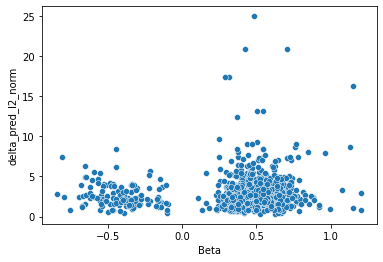

In [23]:
sns.scatterplot(data=df_eQTL, x="Beta", y=delta_norm)

<AxesSubplot:xlabel='p-value', ylabel='delta_pred_l2_norm'>

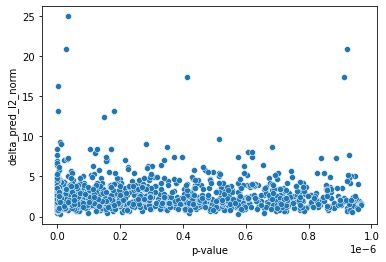

In [24]:
sns.scatterplot(data=df_eQTL, x="p-value", y=delta_norm)

<AxesSubplot:xlabel='t-stat', ylabel='delta_pred_l2_norm'>

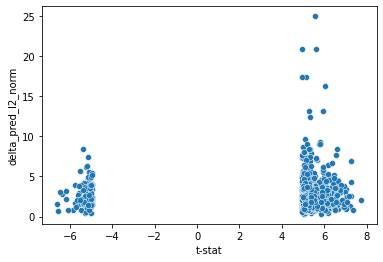

In [25]:
sns.scatterplot(data=df_eQTL, x="t-stat", y=delta_norm)

<AxesSubplot:xlabel='abs_t-stat', ylabel='delta_pred_l2_norm'>

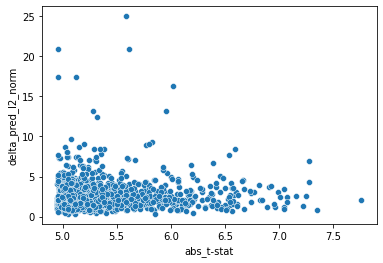

In [26]:
df_eQTL["abs_t-stat"] = df_eQTL["t-stat"].abs()
sns.scatterplot(data=df_eQTL, x="abs_t-stat", y=delta_norm)

In [27]:
spearmanr(df_eQTL["abs_t-stat"], df_eQTL[delta_norm])

SpearmanrResult(correlation=0.019671110181501323, pvalue=0.4938580546835032)

In [28]:
df_eQTL.groupby("closest_TSS").size().nlargest()

closest_TSS
AT5G63570.1    38
AT5G59330.1    22
AT5G41000.1    17
AT5G64650.1    17
AT5G11590.1    15
dtype: int64

In [29]:
df_locus = df_eQTL[df_eQTL.closest_TSS=="AT5G63570.1"]

<AxesSubplot:xlabel='dist_to_TSS', ylabel='delta_pred_l2_norm'>

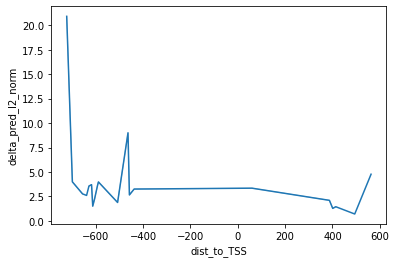

In [30]:
sns.lineplot(data=df_locus, x="dist_to_TSS", y=delta_norm)

<AxesSubplot:xlabel='dist_to_TSS', ylabel='t-stat'>

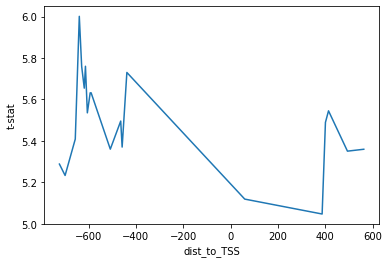

In [31]:
sns.lineplot(data=df_locus, x="dist_to_TSS", y="t-stat", ci=None)

<AxesSubplot:xlabel='dist_to_TSS', ylabel='Beta'>

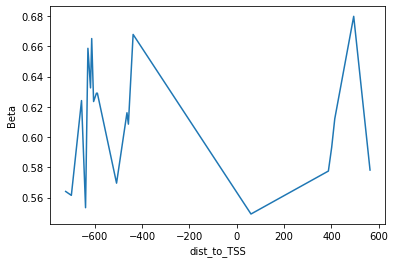

In [32]:
sns.lineplot(data=df_locus, x="dist_to_TSS", y="Beta", ci=None)

In [33]:
spearmanr(df_locus["abs_t-stat"], df_locus[delta_norm])

SpearmanrResult(correlation=-0.019717391731365722, pvalue=0.9064660695937963)